# Rigid-body problem benchmark

- https://benchmarks.sciml.ai/html/NonStiffODE/RigidBody_wpd.html

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Initial value problem: Rigid-body problem">
              Initial-value-problem:-Rigid-body-problem</a></li>

<li><a href="#Work-precision-diagrams">
             Work-precision diagrams</a></li>
    

<li><a href="#Work-precision-diagrams-II-(DiffEqDevTools)">
             Work-precision diagrams-II (DiffEqDevTools) </a></li>

</ul>  

## Loading packages and functions

In [1]:
#using Pkg
#Pkg.status()

In [2]:
using LinearAlgebra
using Plots
using DiffEqDevTools,BenchmarkTools
using OrdinaryDiffEq
using JLD2, FileIO
using Parameters,NBInclude
include("../../IRKGaussLegendre.jl/src/IRKGaussLegendre.jl")
using .IRKGaussLegendre  ## bertsio lokala exekutatzeko

In [3]:
PATH_SRC="../src/"
include(string(PATH_SRC,"MyBenchmarksTools.jl"))
include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   

##### <a href="#top">Back to the top</a>

## Initial value problem: Rigid-body problem



In [4]:
function RigidBody!(du,u,p,t)
  I1=p[1]
  I2=p[2]
  I3=p[3]      
  du[1]  = I1*u[2]*u[3]
  du[2]  = I2*u[1]*u[3]
  du[3]  = I3*u[1]*u[2] +  0.25*sin(t)^2
end 

t0=0.
tF=100.0  # 10.0
tspan=(t0,tF)
tspan_B=(BigFloat(t0),BigFloat(tF))


p = [-2.0,1.25,-0.5]
u0 = [1.0;0.0;0.9]
p_B = BigFloat.([-2.0,1.25,-0.5])
u0_B = BigFloat.([1.0;0.0;0.9])
dim=length(size(u0))

udim=u0[1:1]
prob = ODEProblem(RigidBody!,u0,tspan,p)
prob_B=  ODEProblem(RigidBody!,u0_B,tspan_B,p_B)

sol = solve(prob,Vern9(),abstol=1/10^14,reltol=1/10^14);

In [5]:
plot(sol, xlabel="t", title="Rigid Body problem")

##### <a href="#top">Back to the top</a>

## Work-precision diagrams

### Test-Solution

In [6]:
#sol =solve(prob_B,Vern9(),save_everystep=false, abstol=1e-30,reltol=1e-30)
#@save "./Data/Rigid_Body_sol100.jld2" sol
#test_sol = TestSolution(sol)

@load "./Data/Rigid_Body_sol100.jld2" sol
test_sol = TestSolution(sol)
final_state=sol.u[end]


(Float32(sol.t[end]))

100.0f0

### Integrations 

In [17]:
tols=abstols=reltols=1.0 ./ 10.0 .^ (6:12)

dts8= 4*[0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05]
dtsVern=dts8/3;


In [8]:
nruns=1000

s=8
wp1=launch_IRKGL16_tests(IRKGL16(),final_state, prob, dts8; nruns=nruns)
wp2=launch_IRKGL_simd_tests(final_state, prob, dim, s, dts8,
                            initial_interp=-1, partitioned=false, nruns=nruns)

wp11=launch_method_tests(Vern9(), final_state, prob, tols,  nruns=nruns)
wp12=launch_method_tests(Vern9(), final_state, prob, dtsVern, adaptive=false, nruns=nruns);


### Plots: IRKGL16-simd vs IRKGL16-seq

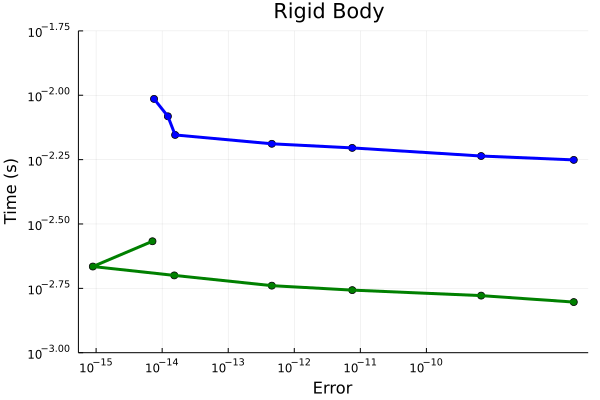

In [14]:
yrange=(10^(-3.0),10^(-1.75))

plot(title="Rigid Body ",xlabel="Error", ylabel="Time (s)", ylims=yrange,
    xticks=[1e-16,1e-15,1e-14,1e-13,1e-12, 1e-11, 1e-10])
# 
plot!(wp1.errors, wp1.times, seriestype=:scatter, scale=:log10, label="", color="blue") 
plot!(wp1.errors, wp1.times, scale=:log10, label="", lw=3, color="blue") #label="IRKGL16_seq"

#
plot!(wp2.errors, wp2.times, seriestype=:scatter, scale=:log10, label="",color="green") 
plot!(wp2.errors, wp2.times, scale=:log10, label="", lw=3, color="green") #label="IRKGL16_simd"
#
#

### Plots: IRKGL16-simd vs Vern9/DPRKN12

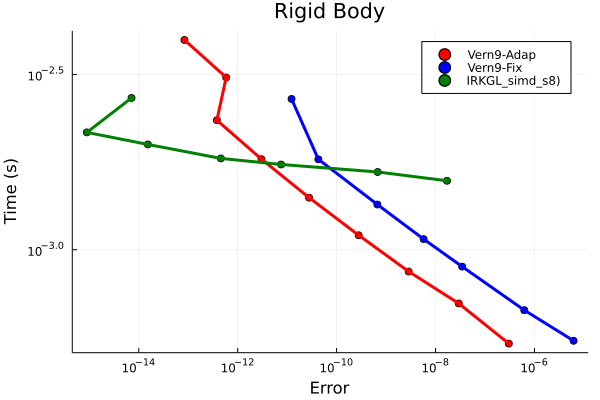

In [10]:
plot(title="Rigid Body",xlabel="Error", ylabel="Time (s)")
# 
plot!(wp11.errors, wp11.times, seriestype=:scatter, scale=:log10, label="Vern9-Adap",color="red")
plot!(wp11.errors, wp11.times, scale=:log10, label="", lw=3, color="red")
#
plot!(wp12.errors, wp12.times, seriestype=:scatter, scale=:log10, label="Vern9-Fix",color="blue")
plot!(wp12.errors, wp12.times, scale=:log10, label="", lw=3, color="blue")
#
#
plot!(wp2.errors, wp2.times, seriestype=:scatter, scale=:log10, label="IRKGL_simd_s8)",color="green")
plot!(wp2.errors, wp2.times, scale=:log10, label="", lw=3, color="green")
#

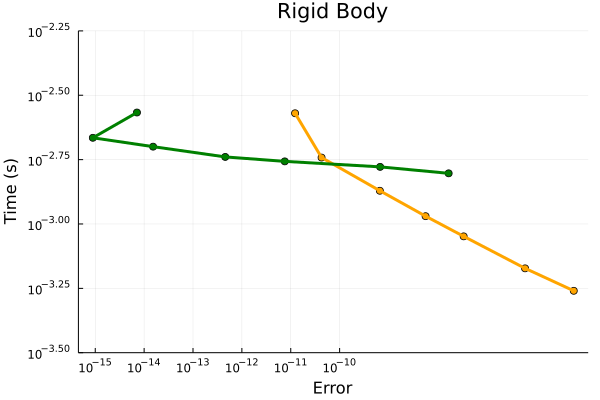

In [12]:
yrange=(10^(-3.5),10^(-2.25))


plot(title="Rigid Body",xlabel="Error", ylabel="Time (s)", ylims=yrange,
       xticks=[1e-16,1e-15,1e-14,1e-13,1e-12, 1e-11, 1e-10])
    
# 
#plot!(wp11.errors, wp11.times, seriestype=:scatter, scale=:log10, label="Vern9-Adap",color="red")
#plot!(wp11.errors, wp11.times, scale=:log10, label="", lw=3, color="red")
#
plot!(wp12.errors, wp12.times, seriestype=:scatter, scale=:log10, label="",color="orange")  #label="Vern9"
plot!(wp12.errors, wp12.times, scale=:log10, label="", lw=3, color="orange")
#
#
plot!(wp2.errors, wp2.times, seriestype=:scatter, scale=:log10, label="",color="green") #label="IRKGL16_simd",
plot!(wp2.errors, wp2.times, scale=:log10, label="", lw=3, color="green")
#
#

##### <a href="#top">Back to the top</a>

## Work-precision diagrams-II (DiffEqDevTools) 

In [19]:
nruns=10
s=8

setups = [
          Dict(:alg=>Vern9(),:adaptive=>false,:dts=>dtsVern)
          Dict(:alg=>IRKGL_simd(s=s, dim=dim,initial_interp=0),:adaptive=>false,:dts=>dts8)
]
solnames = ["Vern9","IRKGL16-simd"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=nruns,names=solnames);



┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

┌ Warning: Warning: Unrecognized keyword arguments found. Future versions will error.
│ The only allowed keyword arguments to `solve` are: 
│ (:dense, :saveat, :save_idxs, :tstops, :d_discontinuities, :save_everystep, :save_on, :save_start, :save_end, :initialize_save, :adaptive, :abstol, :reltol, :dt, :dtmax, :dtmin, :force_dtmin, :internalnorm, :controller, :gamma, :beta1, :beta2, :qmax, :qmin, :qsteady_min, :qsteady_max, :qoldinit, :failfactor, :calck, :alias_u0, :maxiters, :callback, :isoutofdomain, :unstable_check, :verbose, :merge_callbacks, :progress, :progress_steps, :progress_name, :progress_message, :timeseries_errors, :dense_errors, :calculate_errors, :initializealg, :alg, :save_noise, :delta, :seed, :alg_hints, :kwargshandle, :trajectories, :batch_size, :sensealg, :advance_to_tstop, :stop_at_next_tstop)
│ See https://diffeq.sciml.ai/stable/basics/common_solver_opts/ for more details.
│ 
│ Set kwargshandle=KeywordArgError for an error message and more details.
│ Set kwargsha

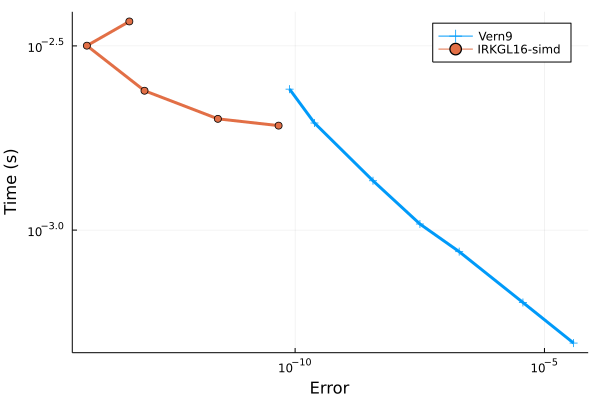

In [20]:
plot(wp)